In [13]:
#!pip install spotpy
import spotpy

import os
import sys
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

# import the cfe model
import bmi_cfe
import cfe

In [26]:
# define working dir
working_dir = '/Users/Sophie/Desktop/CUAHSI/nextgen-form-eval/Calibration'

# define basin list dir
basin_dir = '/Users/Sophie/Desktop/CUAHSI/Data'
basin_filename = 'basin_list_516.txt'
basin_file = os.path.join(basin_dir,basin_filename)

# define config dir
config_dir = os.path.join(working_dir,'configs')

# define observation file dir
#obs_dir = os.path.join(working_dir,'usgs-streamflow')
obs_dir = '/Users/Sophie/Desktop/CUAHSI/Data'

# define result dir
results_path = os.path.join(working_dir,'results')
if os.path.exists(results_path)==False: os.mkdir(results_path)

# define raw result dir
raw_results_path = os.path.join(results_path,'raw')
if os.path.exists(raw_results_path)==False: os.mkdir(raw_results_path)

# define dir to save img
png_dir = os.path.join(results_path,'images')
if os.path.exists(png_dir)==False: os.mkdir(png_dir)

# define dir to save best run results and parameters
best_run_dir = os.path.join(results_path,'best_runs')
if os.path.exists(best_run_dir)==False: os.mkdir(best_run_dir)

# define iteration number
N = 300

## set up spotpy class

In [18]:
class Spotpy_setup(object): 

    def __init__(self,config_file,obs_file): 
        # setup calibration parameters
        self.params = [spotpy.parameter.Uniform('bb',0,21.94),
                       spotpy.parameter.Uniform('smcmax',0.20554,1), #maybe max = 0.5
                       spotpy.parameter.Uniform('satdk',0,0.000726),
                       spotpy.parameter.Uniform('slop',0,1),
                       spotpy.parameter.Uniform('max_gw_storage',0.01,0.25),
                       spotpy.parameter.Uniform('expon',1,8),
                       spotpy.parameter.Uniform('Cgw',1.8e-6,1.8e-3),
                       spotpy.parameter.Uniform('K_lf',0,1),
                       spotpy.parameter.Uniform('K_nash',0,1),
                       ]

        # define config file
        self.config_file = config_file
    
        # Load test comparison data (streamflow) from usgs data
        data = pd.read_csv(obs_file)
        self.obs_data = data['QObs_CAMELS(mm/h)'].values
        self.eval_dates = data['date'].values

        # define calibration period for usgs streamflow obs.
        cal_start_idx_usgs = np.where(self.eval_dates=='2007-10-01 00:00:00')
        cal_end_idx_usgs = np.where(self.eval_dates=='2013-09-30 23:00:00')
        self.eval_dates = self.eval_dates[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
        
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###---------- obs data length: ' +  str(len(self.obs_data)) + '.---------')

    def parameters(self):
        return spotpy.parameter.generate(self.params)
        
    def simulation(self,vector):
        self.cfemodel = bmi_cfe.BMI_CFE(self.config_file)
        print('###--------model succesfully setup----------###')
        self.cfemodel.initialize()
        print('###--------model succesfully initialized----------###')

        with open(self.cfemodel.forcing_file, 'r') as f:
            self.df_forcing = pd.read_csv(f)
        print(f"###----- forcing_file loaded:{self.cfemodel.forcing_file}. -----###")

        # define the calibration period for nldas forcing and usgs streamflow obs.
        cal_start_idx_nldas = np.where(self.df_forcing['date']=='2007-10-01 00:00:00')
        cal_end_idx_nldas = np.where(self.df_forcing['date'].values=='2013-09-30 23:00:00')
        self.df_forcing = self.df_forcing.iloc[cal_start_idx_nldas[0][0]:cal_end_idx_nldas[0][0]+1,:]

        cal_start_idx_usgs = np.where(self.eval_dates=='2007-10-01 00:00:00')
        cal_end_idx_usgs = np.where(self.eval_dates=='2013-09-30 23:00:00')
        self.eval_dates = self.eval_dates[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[cal_start_idx_usgs[0][0]:cal_end_idx_usgs[0][0]+1]
        
        print('###------nldas start date: ' + self.df_forcing['date'].values[0]+ "-----###")
        print('###------nldas end date: ' + self.df_forcing['date'].values[-1]+"-----###")
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###----- nldas forcing data length: ' +  str(len(self.df_forcing['date'].values))+"------###")
        print('###---------- obs data length: ' +  str(len(self.obs_data)) + '.---------')
        
        self.generated_param = vector
        print(f"###----------- parameters generated: {self.generated_param}.--------###")
        self.cfemodel.soil_params['bb']=vector[0]
        self.cfemodel.soil_params['smcmax']=vector[1]
        self.cfemodel.soil_params['satdk']=vector[2]
        self.cfemodel.soil_params['slop']=vector[3]
        self.cfemodel.max_gw_storage==vector[4]
        self.cfemodel.expon=vector[5]
        self.cfemodel.Cgw=vector[6]
        self.cfemodel.K_lf=vector[7]
        self.cfemodel.K_nash=vector[8]

        self.outputs=self.cfemodel.get_output_var_names()
        self.output_lists = {output:[] for output in self.outputs}

        for precip, pet in zip(self.df_forcing['total_precipitation'],self.df_forcing['potential_evaporation']):
            #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
            #sys.exit(1)
            self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip/1000)   #mm/h -> m/h
            self.cfemodel.set_value('water_potential_evaporation_flux', pet/1000/3600) #mm/h -> m/s
            self.cfemodel.update()
        
            for output in self.outputs:
                self.output_lists[output].append(self.cfemodel.get_value(output))
           
        self.cfemodel.finalize(print_mass_balance=True)

        print(f'###----------output length: {len(self.output_lists["land_surface_water__runoff_depth"])}.---------###')

        self.sim_results = np.array(self.output_lists['land_surface_water__runoff_depth']) * 1000      # m/h -> mm/h
        return self.sim_results 

    def evaluation(self,evaldates=False):
        if evaldates:
            self.eval_dates_output = [pd.Timestamp(self.eval_dates[i]) for i in range(len(self.eval_dates))]
            return self.eval_dates_output
        else:
            print(f"###--------- double check - length of obs_data: {len(self.obs_data)}. -----------###")
            return self.obs_data

    def objectivefunction(self,simulation,evaluation, params=None):
        self.obj_function = spotpy.objectivefunctions.kge(evaluation,simulation)
        return self.obj_function

# Run Calibration for each CAMEL

In [19]:
# load basin list
with open(basin_file, "r") as f:
    basin_list = pd.read_csv(f, header=None)

###--------- usgs start date: 2007-10-01 00:00:00.---------
###--------- usgs end date: 2013-09-30 23:00:00.---------
###---------- obs data length: 52608.---------
###--------- double check - length of obs_data: 52608. -----------###
Initializing the  Dynamically Dimensioned Search (DDS) algorithm  with  300  repetitions
The objective function will be maximized
Starting the DDS algotrithm with 300 repetitions...
Finding best starting point for trial 1 using 5 random samples.
###--------model succesfully setup----------###
###--------model succesfully initialized----------###
###----- forcing_file loaded:/Users/Sophie/Desktop/CUAHSI/Data/02231000_hourly_nldas.csv. -----###
###------nldas start date: 2007-10-01 00:00:00-----###
###------nldas end date: 2013-09-30 23:00:00-----###
###--------- usgs start date: 2007-10-01 00:00:00.---------
###--------- usgs end date: 2013-09-30 23:00:00.---------
###----- nldas forcing data length: 52608------###
###---------- obs data length: 52608.----

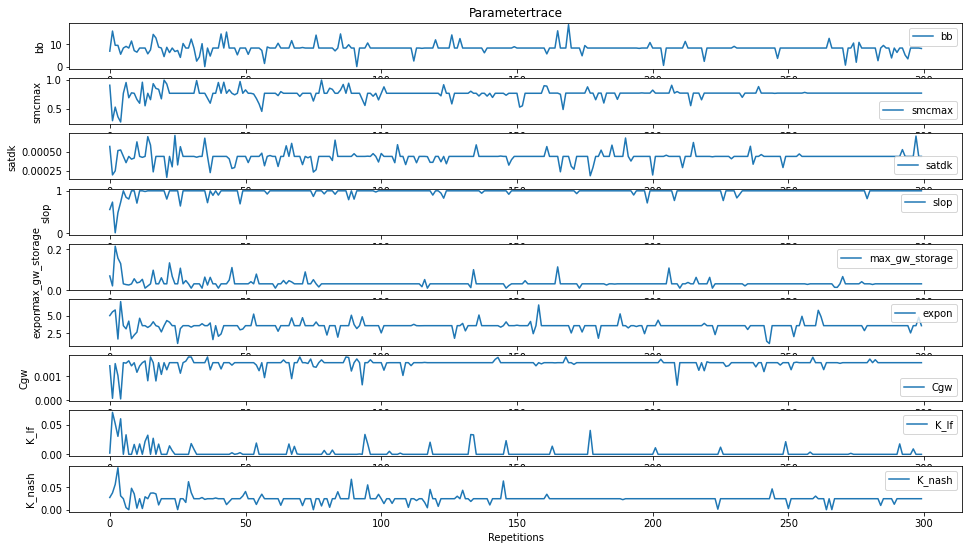

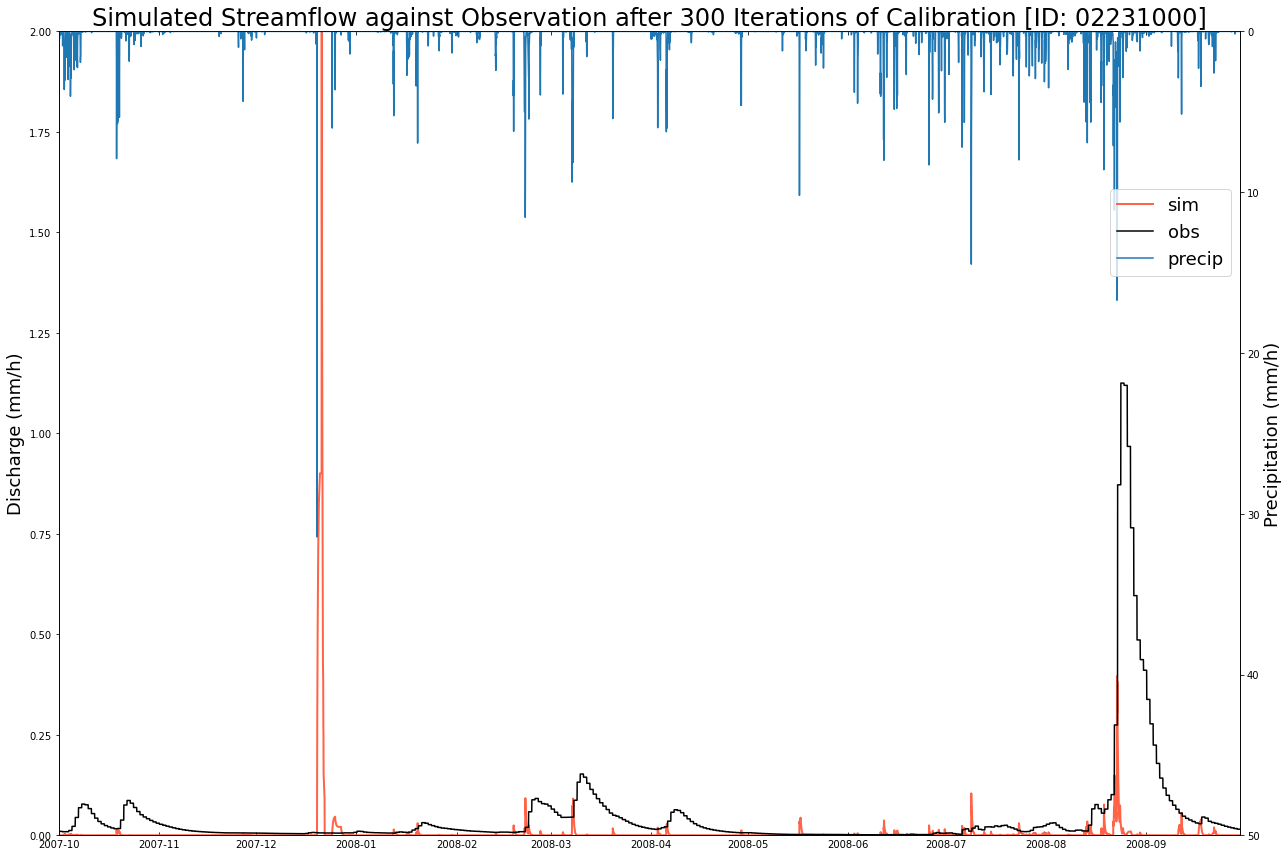

In [20]:
# Loop through each basin
for i in range(basin_list.shape[0]): 
    # if i == 1 : break             # run for the first basin in the list

    if i != 130: continue           # run for a specific basin in the list

    g = basin_list[0][i]

    # import config file
    config_filename = 'cat_' + str(g) + '_bmi_config_cfe.json'
    config_file = os.path.join(config_dir,config_filename)

    # import usgs observation
    obs_filename = '0' + str(g) + '-usgs-hourly.csv'
    obs_file = os.path.join(obs_dir,obs_filename)

    # set up spotpy class
    calibration = Spotpy_setup(config_file = config_file,obs_file = obs_file)

    # define algorithm and export raw result file name
    sampler = spotpy.algorithms.dds(calibration,dbname='raw_result_file',dbformat='ram')

    # start calibration
    sampler.sample(N)

    # export final results
    results = sampler.getdata()

    # all_result_filename = str(g) + '_all_results_dds.npy'
    # all_result_file = os.path.join(raw_results_path,all_result_filename)
    # np.save(all_result_file,results)

    # get best parameters and sim
    best_params = spotpy.analyser.get_best_parameterset(results)

    obj_values=results['like1']
    best_obj_value=np.nanmax(obj_values)
    best_idx=np.where(obj_values==best_obj_value)

    best_sim = spotpy.analyser.get_modelruns(results[best_idx[0][0]])
    best_sim = np.array([best_sim[i] for i in range(len(best_sim))])

    best_run = {"best parameters":list(best_params[0]),"best simulation results": list(best_sim)}

    best_run_filename = str(g) + '_best_run.json'
    best_run_file = os.path.join(best_run_dir,best_run_filename)

    with open(best_run_file, 'w', encoding='utf-8') as f:
        json.dump(best_run, f, ensure_ascii=False, indent=4)

    # plot parameter trace png
    param_trace_imgname = str(g) + '_param_trace.png'
    param_trace_imgfile = os.path.join(png_dir,param_trace_imgname)

    spotpy.analyser.plot_parametertrace(results,fig_name = param_trace_imgfile)

    # plot the figure
    dates = calibration.evaluation(evaldates=True)
    fig, ax1 = plt.subplots(figsize = (18,12)) 
    p1, = ax1.plot(dates[0:8760],best_sim[0:8760],'tomato', linewidth = 2,label = "sim")
    p2, = ax1.plot(dates[0:8760],calibration.obs_data[0:8760],'k',label = "obs")
    ax1.set_ylabel('Discharge (mm/h)',fontsize = 18)
    ax1.set_ylim([0,2])
    ax1.margins(x=0)
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_label_position('bottom')
    ax1.tick_params(axis="x",direction="in")
    ax2 = ax1.twinx()
    p3, = ax2.plot(dates[0:8760],calibration.df_forcing['total_precipitation'][0:8760],'tab:blue', label = "precip")
    ax2.set_ylim([50,0])
    ax2.margins(x=0)
    #ax2.invert_yaxis()
    ax2.set_ylabel('Precipitation (mm/h)',fontsize = 18)
    ax2.set_xlabel('Date', fontsize = 18)
    plt.legend(handles = [p1,p2,p3],fontsize = 18, loc='right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
    plt.title(f"Simulated Streamflow against Observation after {N} Iterations of Calibration [ID: 0{g}]", fontsize = 24)
    plt.tight_layout()
    #plt.show()

    comparison_imgname = str(g) + "_comparison.png"
    comparison_imgfile = os.path.join(png_dir,comparison_imgname)
    plt.savefig(comparison_imgfile,bbox_inches='tight')


# Evaluate and Plot Results

Best parameter set:
bb=8.305791245241055, smcmax=0.7699047429431312, satdk=0.00043821262185378906, slop=0.997, max_gw_storage=0.03125393394858982, expon=3.564053302942856, Cgw=0.0015637070166415314, K_lf=2.66e-05, K_nash=0.02446760206931434
The figure as been saved as "/Users/Sophie/Desktop/CUAHSI/nextgen-form-eval/Calibration/results/images/2231000_param_trace.png


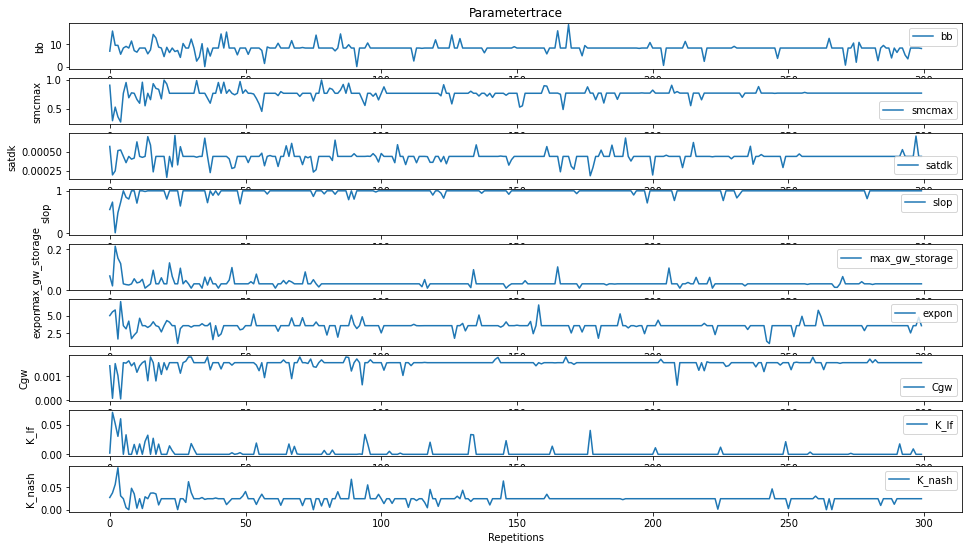

In [21]:
# Loop through each basin
# for i in range(basin_list.shape[0]): 
    #if i == 1 : break
# i = 130

# g = basin_list[0][i]

# # load results from each basin
# all_result_filename = str(g) + '_all_results_dds.npy'
# all_result_file = os.path.join(raw_results_path,all_result_filename)
# results = np.load(all_result_file)

# get best parameters and sim
best_params = spotpy.analyser.get_best_parameterset(results)

obj_values=results['like1']
best_obj_value=np.nanmax(obj_values)
best_idx=np.where(obj_values==best_obj_value)

best_sim = spotpy.analyser.get_modelruns(results[best_idx[0][0]])
best_sim = np.array([best_sim[i] for i in range(len(best_sim))])

best_run = {"best parameters":list(best_params[0]),"best objective value": best_obj_value, "best simulation results": list(best_sim)}

best_run_filename = str(g) + '_best_run.json'
best_run_file = os.path.join(best_run_dir,best_run_filename)

with open(best_run_file, 'w', encoding='utf-8') as f:
    json.dump(best_run, f, ensure_ascii=False, indent=4)

# plot parameter trace png
param_trace_imgname = str(g) + '_param_trace.png'
param_trace_imgfile = os.path.join(png_dir,param_trace_imgname)

spotpy.analyser.plot_parametertrace(results,fig_name = param_trace_imgfile)


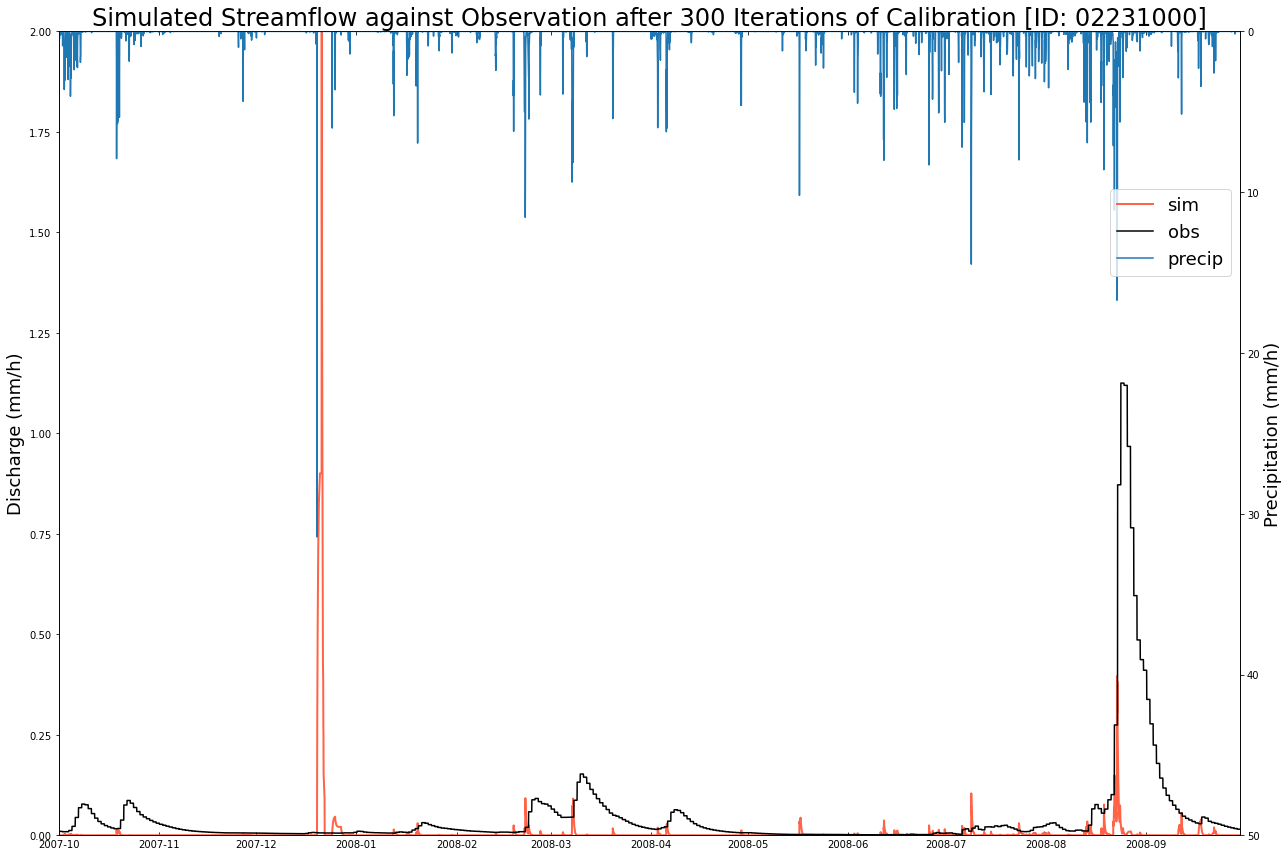

In [22]:
# plot simulation results against observation
for i in range(basin_list.shape[0]): 
    # if i == 1 : break

    if i != 130: continue

    g = basin_list[0][i]

    # load obs data
    obs_filename = '0' + str(g) + '-usgs-hourly.csv'
    obs_file = os.path.join(obs_dir,obs_filename)
    data = pd.read_csv(obs_file)

    obs_data = data['QObs_CAMELS(mm/h)'].values
    eval_dates = data['date'].values

    # define start time and end calibration period for usgs streamflow obs.
    cal_start_idx_usgs = np.where(eval_dates=='2007-10-01 00:00:00')
    eval_dates = eval_dates[cal_start_idx_usgs[0][0]:]
    obs_data = obs_data[cal_start_idx_usgs[0][0]:]

    cal_end_idx_usgs = np.where(eval_dates=='2013-09-30 23:00:00')
    eval_dates = eval_dates[:cal_end_idx_usgs[0][0]+1]
    obs_data = obs_data[:cal_end_idx_usgs[0][0]+1]

    eval_dates = [pd.Timestamp(eval_dates[i]) for i in range(len(eval_dates))]

    # import precipitation data
    forcing_filename = '0' + str(g) + '_hourly_nldas.csv'
    forcing_file = os.path.join(obs_dir,forcing_filename)
    with open(forcing_file, 'r') as f: df_forcing = pd.read_csv(f)

    precip = df_forcing['total_precipitation']

    cal_start_idx_nldas = np.where(df_forcing['date']=='2007-10-01 00:00:00')
    cal_end_idx_nldas = np.where(df_forcing['date'].values=='2013-09-30 23:00:00')

    precip = precip.iloc[cal_start_idx_nldas[0][0]:cal_end_idx_nldas[0][0]+1]

    # load best sim results
    best_run_filename = str(g) + '_best_run.json'
    best_run_file = os.path.join(best_run_dir,best_run_filename)
    f = open(best_run_file)
    best_run = json.load(f)
    f.close()
    best_sim = np.array(best_run['best simulation results'])

    # plot the figure
    fig, ax1 = plt.subplots(figsize = (18,12)) 
    p1, = ax1.plot(eval_dates[0:8760],best_sim[0:8760],'tomato', linewidth = 2,label = "sim")
    p2, = ax1.plot(eval_dates[0:8760],obs_data[0:8760],'k',label = "obs")
    ax1.set_ylabel('Discharge (mm/h)',fontsize = 18)
    ax1.set_ylim([0,2])
    ax1.margins(x=0)
    ax1.xaxis.set_ticks_position('both')
    ax1.xaxis.set_label_position('bottom')
    ax1.tick_params(axis="x",direction="in")
    ax2 = ax1.twinx()
    p3, = ax2.plot(eval_dates[0:8760],precip[0:8760],'tab:blue', label = "precip")
    ax2.set_ylim([50,0])
    ax2.margins(x=0)
    #ax2.invert_yaxis()
    ax2.set_ylabel('Precipitation (mm/h)',fontsize = 18)
    ax2.set_xlabel('Date', fontsize = 18)
    plt.legend(handles = [p1,p2,p3],fontsize = 18, loc='right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
    plt.title(f"Simulated Streamflow against Observation after {N} Iterations of Calibration [ID: 0{g}]", fontsize = 24)
    plt.tight_layout()
    #plt.show()

    comparison_imgname = str(g) + "_comparison.png"
    comparison_imgfile = os.path.join(png_dir,comparison_imgname)
    plt.savefig(comparison_imgfile,bbox_inches='tight')


In [25]:
print(f"mean discharge: {np.mean(np.array(calibration.output_lists['land_surface_water__runoff_depth']))*1000} mm/h.")
flux = np.mean(np.array(calibration.output_lists['land_surface_water__runoff_volume_flux']))
print(f"mean flux converted discharge: {flux/(1748.37*(10**6))*1000} mm/h.")
print(f"mean observed discharge: {np.mean(calibration.obs_data)} mm/h.")

mean discharge: 0.009245352477342568 mm/h.
mean flux converted discharge: 0.009245352477342568 mm/h.
mean observed discharge: 0.027071798676615258 mm/h.


In [24]:
np.max(np.array(calibration.output_lists['land_surface_water__runoff_depth']))*1000
np.max(calibration.obs_data)

1.8731885482839663

In [30]:
calibration.cfemodel.current_time

Timestamp('2013-10-01 00:00:00')